In [17]:
from patch.utils import embed_to_distrib, top_vals, format_token, intervene_node_and_pos
from patch.models.gpt2 import GPT2, create_gpt2
import sys

config, tokenizer, model = create_gpt2('gpt2-medium')
model = GPT2(config, model, verbose=False)

loaded model


In [26]:
inputs = [
    tokenizer("<|endoftext|>The councilmen refused the demonstrators a permit because they advocated violence. They were upset.", return_tensors="pt"),
    tokenizer("<|endoftext|>The councilmen refused the demonstrators a permit because they feared violence. They were upset.", return_tensors="pt")
]
print(inputs)
assert len(inputs[0]['input_ids'][0]) == len(inputs[1]['input_ids'][0])

[{'input_ids': tensor([[50256,   464,  6745,  3653,  6520,   262, 25016,   257,  8749,   780,
           484, 25828,  3685,    13,  1119,   547,  9247,    13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}, {'input_ids': tensor([[50256,   464,  6745,  3653,  6520,   262, 25016,   257,  8749,   780,
           484, 15240,  3685,    13,  1119,   547,  9247,    13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}]


In [27]:
res1, cache1 = model(inputs, which=lambda x: 0, verbose=False)
distrib1 = embed_to_distrib(model, res1.hidden_states, logits=False)
top_vals(tokenizer, distrib1[0][-1], n=10)
print('-----')

res2, cache2 = model(inputs, which=lambda x: 1, verbose=False)
distrib2 = embed_to_distrib(model, res2.hidden_states, logits=False)
top_vals(tokenizer, distrib2[0][-1], n=10)

\n                   0.2827657461166382
_They                0.19959668815135956
_The                 0.06078444793820381
_"                   0.054455243051052094
_But                 0.022235117852687836
_And                 0.02129100263118744
_A                   0.013480931520462036
_So                  0.012421774677932262
_Some                0.011408692225813866
_It                  0.010982017032802105
-----
\n                   0.26295018196105957
_They                0.18380846083164215
_The                 0.06317982077598572
_"                   0.06262170523405075
_But                 0.02509211376309395
_And                 0.019019437953829765
_A                   0.016189688816666603
_Some                0.014313316904008389
_In                  0.011585795320570469
_One                 0.011214782483875751


100%|██████████| 49/49 [03:24<00:00,  4.17s/it]


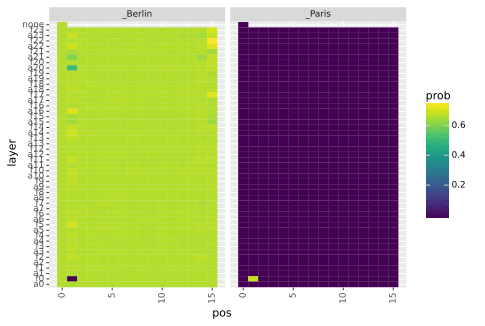

In [10]:
%config InlineBackend.figure_formats = ['svg']

df, nodes, g = intervene_node_and_pos(model, tokenizer, inputs, tokens=[' Berlin', ' Paris'], plot=True, pause=False)
print(g)

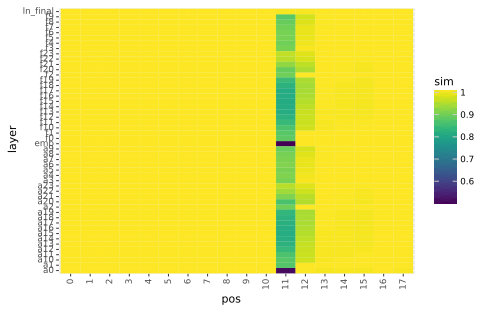

In [29]:
import torch
import pandas as pd
from plotnine import ggplot, geom_tile, aes, facet_wrap, theme, element_text

data = []

for key in cache1:
    if 'head' in key.parent:
        continue
    ret1 = cache1[key].hidden_states
    for key2 in cache2:
        if key2.parent == key.parent:
            ret2 = cache2[key2].hidden_states

    # get cosine similarity
    sim = torch.nn.functional.cosine_similarity(ret1, ret2, dim=-1)
    for tok in range(sim.shape[1]):
        data.append({
            'layer': key.parent,
            'pos': tok,
            'sim': sim[0, tok].item()
        })


df = pd.DataFrame(data)
df["pos"] = df["pos"].astype("category")

g = (
    ggplot(df)
    + geom_tile(aes(x="pos", y="layer", fill="sim", color="sim"))
    + theme(axis_text_x=element_text(rotation=90))
)
print(g)

In [12]:
# # in df filter for token='Paris' and sort by prob
# df[df.token == '_Paris'].sort_values('prob', ascending=False).head(10)